# 1. Data Loading and Preprocessing the Data

### Let’s load the dataset and prepare it for training. You’ll need to read the CSV file, handle missing data, and scale the data.

         Date   Open   High    Low  Close  Adj Close    Volume
0  2010-06-29  3.800  5.000  3.508  4.778      4.778  93831500
1  2010-06-30  5.158  6.084  4.660  4.766      4.766  85935500
2  2010-07-01  5.000  5.184  4.054  4.392      4.392  41094000
3  2010-07-02  4.600  4.620  3.742  3.840      3.840  25699000
4  2010-07-06  4.000  4.000  3.166  3.222      3.222  34334500


<ipython-input-1-515f833dc0b2>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


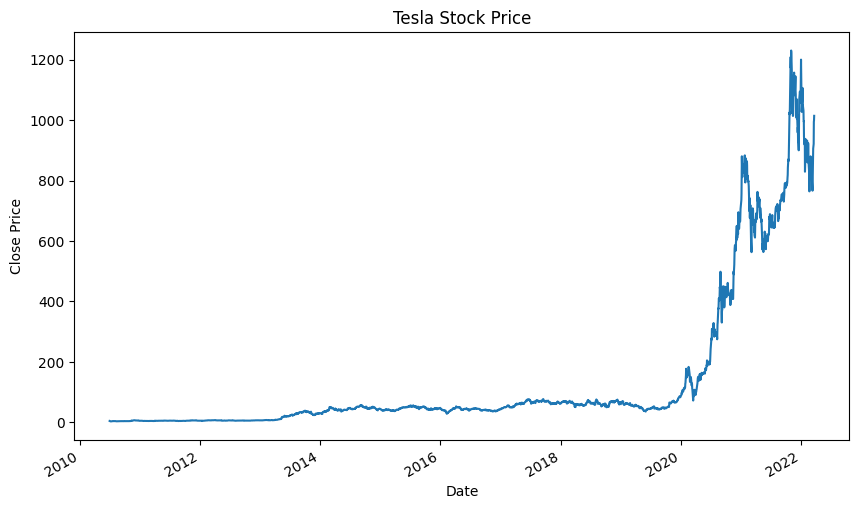

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load the Tesla stock data
df = pd.read_csv('/kaggle/input/tesla-stock-data-updated-till-28jun2021/TSLA.csv')  

# Display the first few rows
print(df.head())

# We are interested in the 'Close' price
data = df[['Date', 'Close']]

# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Set the 'Date' column as the index
data.set_index('Date', inplace=True)

# Plot the 'Close' price over time
data['Close'].plot(figsize=(10, 6))
plt.title('Tesla Stock Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()


# 2. Normalize the Data

### We need to normalize the stock prices to a range between 0 and 1, so that the LSTM can learn better:

In [2]:
# Normalize the 'Close' prices
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

# Create sequences (X) and labels (y)
sequence_length = 60  # Using the past 60 days to predict the next day

X = []
y = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 0])  # Past 60 days of closing prices
    y.append(scaled_data[i, 0])  # The closing price of the next day

X, y = np.array(X), np.array(y)

# Reshape X to be compatible with LSTM input (samples, time_steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (2316, 60, 1)
X_test shape: (580, 60, 1)


# 3. Build the LSTM Model

### Let’s create an LSTM model for stock price prediction:

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Initialize the LSTM model
model = Sequential()

# Add LSTM layers
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Add the output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 2.8817e-04 - val_loss: 0.0069
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 1.7254e-05 - val_loss: 0.0064
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 1.2551e-05 - val_loss: 0.0041
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 1.1906e-05 - val_loss: 0.0045
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 1.0242e-05 - val_loss: 0.0039
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 9.5921e-06 - val_loss: 0.0034
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 9.5677e-06 - val_loss: 0.0027
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 7.8291e-06 - val_loss: 0.0025
Epoch 9/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 7.7391e-06 - val_loss: 0.0040
Epoch 10/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 9.4747e-06 - val_loss: 0.0040


# 4. Evaluate the Model and Make Predictions

### Let’s evaluate the model performance and predict stock prices:

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
RMSE: 77.48724275887116


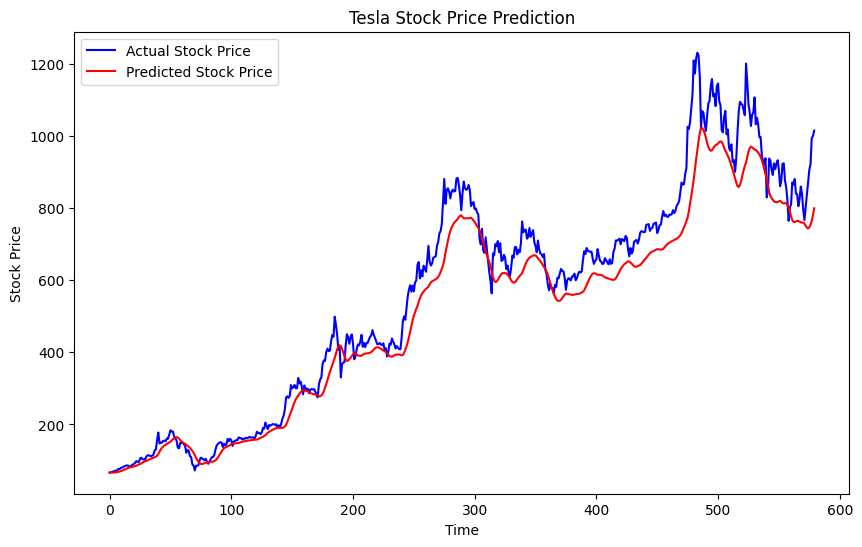

In [4]:
# Predict the stock prices
predicted_stock_price = model.predict(X_test)

# Inverse transform the predictions and actual values to get the real prices
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(np.mean(np.square(predicted_stock_price - y_test_actual)))
print(f"RMSE: {rmse}")

# Plot the predicted vs actual stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, color='blue', label='Actual Stock Price')
plt.plot(predicted_stock_price, color='red', label='Predicted Stock Price')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()